## Preliminaries  
The methods and loss functions are implemented in the optmethods package. Our first step is install it from git.

In [1]:
!pip install git+https://github.com/konstmish/opt_methods.git

  Cloning https://github.com/konstmish/opt_methods.git to /private/var/folders/bh/ksb5sf_15577shnrwg38rtt00000gr/T/pip-req-build-7fskrrtf
  Running command git clone --filter=blob:none --quiet https://github.com/konstmish/opt_methods.git /private/var/folders/bh/ksb5sf_15577shnrwg38rtt00000gr/T/pip-req-build-7fskrrtf
  Resolved https://github.com/konstmish/opt_methods.git to commit b500ac3f3cccdf22e11510cd30a2630d031b3aab
  Preparing metadata (setup.py) ... done
  Created wheel for opt-methods: filename=opt_methods-0.1.1-py3-none-any.whl size=55909 sha256=ddb2e86bc3ef4a94fafc656778d46484d224d72c1f827199159b6605ca93c4d1
  Stored in directory: /private/var/folders/bh/ksb5sf_15577shnrwg38rtt00000gr/T/pip-ephem-wheel-cache-o0twnffl/wheels/bf/b4/48/3c91e0f1794f4eeba87acece649fcbd94f4b9a93674874633b
Successfully built opt-methods


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import numpy.linalg as la

from optmethods.datasets import get_dataset
from optmethods.line_search import Armijo
from optmethods.loss import LogisticRegression, LogSumExp
from optmethods.first_order import Gd, RestNest, NestLine
from optmethods.second_order import Cubic, Newton, RegNewton, Arc

import matplotlib
sns.set(style="whitegrid", context="talk", palette=sns.color_palette("bright"), color_codes=False)

## The methods

We are going to compare the following methods:


*   GD: Gradient Descent with constant stepsize, $x^{k+1}=x^k - \frac{1}{L}\nabla f(x^k)$
*   Nesterov's acceleration with constant stepsize and restarts, $x^{k+1}=y^k - \frac{1}{L}\nabla f(y^k)$, $y^{k+1}=x^{k+1}+\beta_k(x^{k+1}-x^k)$
*   Cubic Newton of Nesterov and Polyak, $x^{k+1}=\arg\min_x\left\{\langle \nabla f(x^k), x-x^k\rangle + \frac{1}{2}\nabla^2 f(x^k)[x-x^k]^2 + \frac{H}{3}\|x-x^k\|^3 \right\}$
*   Newton-Armijo: standard Newton with Armijo line search, $x^{k+1} = x^k - \alpha_k (\nabla^2 f(x^k))^{-1}\nabla f(x^k)$
*   Our Global Newton with constant $H$, $x^{k+1} = x^k - \alpha_k (\nabla^2 f(x^k) + \lambda_k\mathbf{I})^{-1}\nabla f(x^k)$, $\lambda_k=\sqrt{H\|\nabla f(x^k)\|}$
*   AdaN: Our Global Newton with line search for estimating $H$, $x^{k+1} = x^k - \alpha_k (\nabla^2 f(x^k) + \lambda_k\mathbf{I})^{-1}\nabla f(x^k)$, $\lambda_k=\sqrt{H_k\|\nabla f(x^k)\|}$
*   AdaN+: Our Global Newton with heuristic estimation of $H$, $x^{k+1} = x^k - \alpha_k (\nabla^2 f(x^k) + \lambda_k\mathbf{I})^{-1}\nabla f(x^k)$, $\lambda_k=\sqrt{H_k\|\nabla f(x^k)\|}$

You can find the implementation of the proposed Newton method by following this link: https://github.com/konstmish/opt_methods/blob/master/optmethods/second_order/reg_newton.py#L19


In [3]:
def setup_basic_optimizers(loss):
    gd = Gd(loss=loss, label='GD')
    rest = RestNest(loss=loss, doubling=True, label="Nesterov's acceleration")
    cub = Cubic(loss=loss, label='Cubic Newton')
    gnewt = RegNewton(loss=loss, adaptive=False, use_line_search=False, 
                      label='Global Newton')
    return [gd, rest, cub, gnewt]

def setup_adaptive_optimizers(loss):
    armgd = Gd(loss=loss, label='GD-Armijo', line_search=Armijo())
    armnest = NestLine(loss=loss, label="Nesterov-Armijo")
    armn = Newton(loss=loss, line_search=Armijo(), label='Newton-Armijo')
    arc = Arc(loss=loss, solver_eps=0.005, sigma=1, label='Arc')
    adan = RegNewton(loss=loss, adaptive=True, use_line_search=True, 
                     label='AdaN')
    adanp = RegNewton(loss=loss, adaptive=True, use_line_search=False, 
                      label='AdaN+')
    return [armgd, armnest, armn, adan, adanp, arc]

markers = [',', 'o', '^', '*', 'd', 's', 'X', 'P', '.', 6, 7]

## Easy problem: Logistic Regression

In [4]:
import sklearn.datasets
import urllib.request
dataset = 'w8a'
if dataset == 'mushrooms':
    data_url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/mushrooms"
    data_path = './mushrooms'
else:
    data_url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/w8a"
    data_path = './w8a'
f = urllib.request.urlretrieve(data_url, data_path)
A, b = sklearn.datasets.load_svmlight_file(data_path)
A = A.toarray()

loss = LogisticRegression(A, b, l1=0, l2=0)
n, dim = A.shape
L = loss.smoothness
l2 = 1e-10 * L # make the problem ill-conditioned
loss.l2 = l2
x0 = np.ones(dim) * 0.5
it_max = 600

In [5]:
optimizers_basic = setup_basic_optimizers(loss)
# optimizers_ada = setup_adaptive_optimizers(loss)

for opt in optimizers_basic:
    print(f'Running optimizer: {opt.label}')
    opt.run(x0=x0, it_max=it_max)
    opt.compute_loss_of_iterates()

Running optimizer: GD


100%|██████████| 600/600 [00:09<00:00, 61.91it/s]


Running optimizer: Nesterov's acceleration


100%|██████████| 600/600 [00:09<00:00, 62.36it/s]


Running optimizer: Cubic Newton


100%|██████████| 600/600 [02:30<00:00,  3.99it/s]


Running optimizer: Global Newton


100%|██████████| 600/600 [02:40<00:00,  3.74it/s]


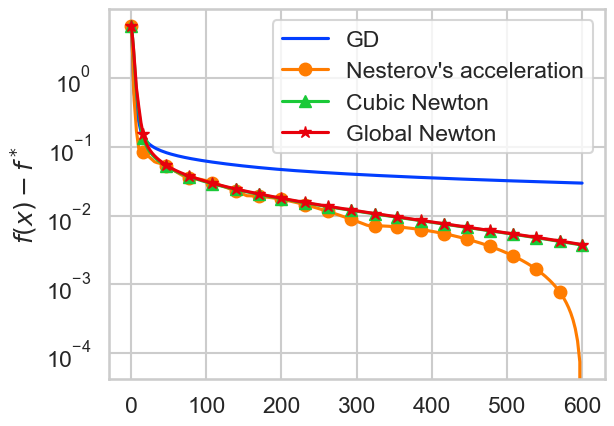

In [6]:
for opt, marker in zip(optimizers_basic, markers):
    opt.trace.plot_losses(marker=marker)

plt.yscale('log')
plt.legend()
plt.savefig(f'logistic_{dataset}_basic.pdf', bbox_inches='tight')

In [9]:
print(optimizers_basic[0].trace.loss_vals)

[5.81129951 3.91969657 2.1959998  1.06643721 0.71961005 0.60456866
 0.53265601 0.47582529 0.35047109 0.28502646 0.25720101 0.24229704
 0.23249664 0.2253244  0.2197384  0.2152061  0.21141955 0.20818517
 0.2053738  0.20213124 0.19999815 0.19807081 0.19631533 0.19470518
 0.19321928 0.19184064 0.19055536 0.18935198 0.18822093 0.18715416
 0.18614481 0.18518702 0.18398155 0.18312558 0.18230676 0.18152189
 0.18076817 0.1800431  0.17934449 0.17867041 0.17801912 0.17738908
 0.17677892 0.17618742 0.17561348 0.17487388 0.17433731 0.17381543
 0.17330757 0.17281315 0.17233161 0.17186248 0.17140532 0.17095975
 0.17052539 0.17010193 0.16968905 0.16928646 0.16876522 0.1683856
 0.1680154  0.16765437 0.16730226 0.16695883 0.16662383 0.16629701
 0.16597814 0.16566696 0.16536323 0.16506671 0.16477716 0.16440152
 0.16412729 0.16385924 0.16359715 0.16334078 0.16308993 0.16284438
 0.16260393 0.16236839 0.16213756 0.16191128 0.16168935 0.16147163
 0.16118759 0.16097907 0.16077424 0.16057298 0.16037516 0.16018

Line search iteration counter is used for plotting GD-Armijo
Line search iteration counter is used for plotting Nesterov-Armijo
Line search iteration counter is used for plotting Newton-Armijo
Line search iteration counter is used for plotting AdaN
Line search iteration counter is used for plotting Arc


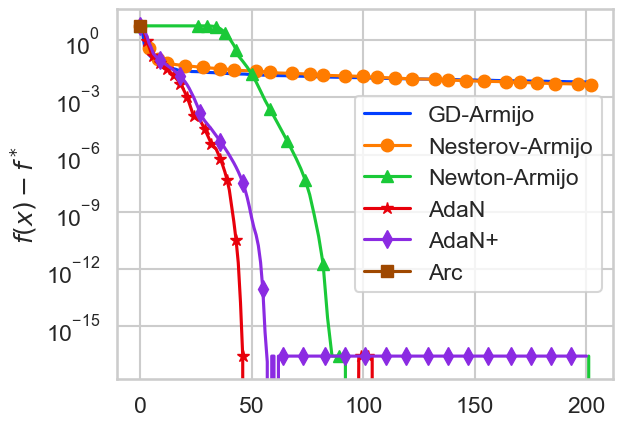

In [18]:
for opt, marker in zip(optimizers_ada, markers):
    opt.trace.plot_losses(f_opt=loss.f_opt, marker=marker)
plt.yscale('log')
plt.legend()
plt.savefig(f'logistic_{dataset}_adaptive.pdf', bbox_inches='tight')

## Hard problem: Log-Sum-Exp

Now we consider the following objective  
$\qquad f(x) = \rho\log\left(\sum_{i=1}^n \exp\left(\frac{a_i^\top x - b_i}{\rho}\right)\right) ,$  
where $a_1,\dotsc, a_n\in\mathbb{R}^d$ are some vectors and $\rho, b_1,\dotsc, b_n, \in \mathbb{R}$ are scalars.

Function $f$ is a smooth approximation of $\max\{a_1^\top x-b_1,\dotsc, a_n^\top x - b_n\}$. Its gradient, Hessian and even higher-order terms have closed-form solutions. The motivation for introducing $\rho$ is simply that it tightens the approximation, namely  
$\qquad \max\{\alpha_1,\dotsc, \alpha_n\} \le \rho\log\left(\sum_{i=1}^n\exp\left(\frac{\alpha_i}{\rho}\right)\right) \le \max\{\alpha_1,\dotsc, \alpha_n\} + \rho \log n,$  
At the same time, $f$ can sometimes be very ill-conditioned, so first-order methods might struggle when minimizing it. In particular, as $\rho$ approaches 0, $f$ becomes much harder to minimize. Below, we are going to use $\rho=0.25$, which, as we will see, too challenging for Newton with Armijo line search.

In [9]:
seed = 0
rng = np.random.default_rng(seed)
n, dim = 500, 200
least_squares_term = False
max_smoothing = 0.05
l2 = 0
loss = LogSumExp(n=n, dim=dim, least_squares_term=least_squares_term, l2=l2, 
                 max_smoothing=max_smoothing)
x0 = rng.normal(scale=0.5, size=dim)

In [10]:
optimizers_basic = setup_basic_optimizers(loss)
optimizers_ada = setup_adaptive_optimizers(loss)

it_max = 4000

for opt in optimizers_basic:
    print(f'Running optimizer: {opt.label}')
    opt.run(x0=x0, it_max=it_max)
    opt.compute_loss_of_iterates()
    
it_max = 1500
    
for opt in optimizers_ada:
    print(f'Running optimizer: {opt.label}')
    opt.run(x0=x0, it_max=it_max)
    opt.compute_loss_of_iterates()

Running optimizer: GD
Running optimizer: Nesterov's acceleration
Running optimizer: Cubic Newton
Running optimizer: Global Newton
Running optimizer: GD-Armijo
Running optimizer: Nesterov-Armijo
Running optimizer: Newton-Armijo
Running optimizer: AdaN
Running optimizer: AdaN+
Running optimizer: Arc


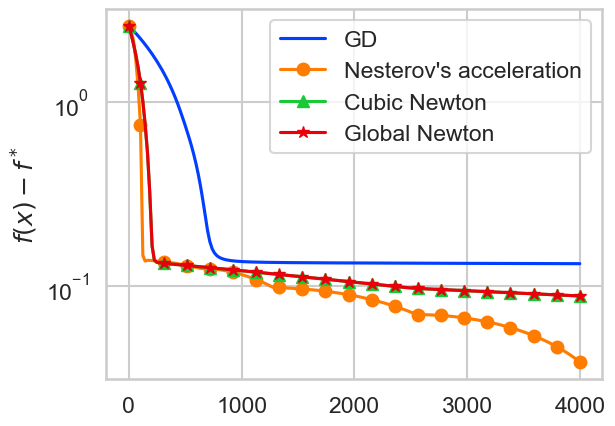

In [11]:
for opt, marker in zip(optimizers_basic, markers):
    opt.trace.plot_losses(marker=marker)
plt.yscale('log')
plt.legend()
plt.savefig(f'logsumexp_{max_smoothing}_basic.pdf', bbox_inches='tight')

Line search iteration counter is used for plotting GD-Armijo
Line search iteration counter is used for plotting Nesterov-Armijo
Line search iteration counter is used for plotting Newton-Armijo
Line search iteration counter is used for plotting AdaN
Line search iteration counter is used for plotting Arc


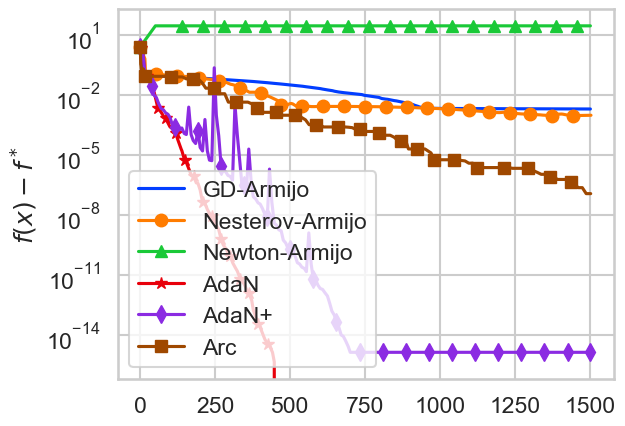

In [12]:
for opt, marker in zip(optimizers_ada, markers):
    opt.trace.plot_losses(marker=marker)
plt.yscale('log')
plt.legend()
plt.savefig(f'logsumexp_{max_smoothing}_adaptive.pdf', bbox_inches='tight')

## Source code links
Here we provide links to the source code of the new methods and objective functions:  
[The method](https://github.com/konstmish/opt_methods/blob/master/optmethods/second_order/reg_newton.py#L19)  
[The line search](https://github.com/konstmish/opt_methods/blob/master/optmethods/line_search/reg_newton_ls.py)  
[Logistic regression oracle](https://github.com/konstmish/opt_methods/blob/master/optmethods/loss/logistic_regression.py) that produces gradients and Hessians  
[Log-sum-exp oracle](https://github.com/konstmish/opt_methods/blob/master/optmethods/loss/log_sum_exp.py) that produces gradients and Hessians

## Conclusions
From both examples, we can see that second-order method with estimation of smoothness (Newton-Armijo, AdaN, AdaN+) work much better for both problems. However, Newton-Armijo fails to solve the second problem due to its ill-conditioning. It is also pedagogical to try to remove $\ell_2$ regularization from the first example, in which case Newton-Armijo would fail because of numpy.linalg solver complaining about the singularity of the Hesssian. To conclude, even though on many problems standard Newton method is already sufficient, there are many others where it is not, and AdaN offers a stable replacement.

-------